In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import json
from datasets import load_dataset
import os

dataset = load_dataset("hendrycks/competition_math")
train_questions = np.array(dataset["train"]["problem"])
train_answers = np.array(dataset["train"]['solution'])

test_questions = dataset["test"]["problem"]
test_answers = dataset["test"]['solution']


/data/katie_kang/miniconda3/envs/trlx2/lib/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for hendrycks/competition_math contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hendrycks/competition_math
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [2]:
def get_stats(train_name):
    num_memorized_all = []
    num_correct_different_all = []
    num_incorrect_all = []
    perplexities_all = []


    ckpts = sorted([
    f for f in os.listdir("ckpts/"+train_name) if os.path.isdir(os.path.join("ckpts/"+train_name, f))
    ], key=lambda x: int(x.split('-')[1]))
    print(ckpts)
    
    
    
    train_samples_all = []

    for ckpt in ckpts:
        try:
            train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2.npy")==0)
            train_samples = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answers5_seed2.npy"))
        except:
            train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2_temp0.8.npy")==0)
            train_samples = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answers5_seed2_temp0.8.npy"))
            
        if ("half" in train_name) or ("quarter" in train_name) or ("eighth" in train_name):
            subsample_idxs = np.load("ckpts/"+train_name+"/subsample_idxs.npy")
            train_correct = train_correct[subsample_idxs]
            train_samples = train_samples[subsample_idxs]
        else:
            subsample_idxs = np.arange(len(train_answers))

        train_samples_all.append(train_samples)
        num_memorized_ckpt = []
        num_correct_different_ckpt = []
        num_incorrect_ckpt = []

        for input_idx in range(len(subsample_idxs)):
            num_memorized = 0
            num_correct_different = 0
            num_incorrect = 0
            for sample_idx in range(5):
                correct = train_correct[input_idx, sample_idx]
                if correct:
                    if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                        num_memorized+=1
                    else:
                        num_correct_different+=1
                else:
                    num_incorrect+=1 
            num_memorized_ckpt.append(num_memorized)
            num_correct_different_ckpt.append(num_correct_different)
            num_incorrect_ckpt.append(num_incorrect)
        
        num_memorized_all.append(num_memorized_ckpt)
        num_correct_different_all.append(num_correct_different_ckpt)
        num_incorrect_all.append(num_incorrect_ckpt)
        
        
        perplexities = np.load("ckpts/"+train_name+"/"+ckpt+ "/train_perplexities.npy")[subsample_idxs]
        perplexities_all.append(perplexities)
        
    num_memorized_all = np.array(num_memorized_all)
    num_correct_different_all = np.array(num_correct_different_all)
    num_incorrect_all = np.array(num_incorrect_all)
    perplexities_all = np.array(perplexities_all)
    train_samples_all = np.array(train_samples_all)
    
    test_accs_all = []
    test_samples_all = []

    for ckpt in ckpts:
        try:
            test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types5_seed2.npy")==0)
            test_samples = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answers5_seed2.npy"))
        except:
            try:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2_temp0.8.npy")==0)
                test_samples = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answers50_seed2_temp0.8.npy"))
            except:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types5_seed2_temp0.8.npy")==0)
                test_samples = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answers5_seed2_temp0.8.npy"))
        test_accs_all.append(test_accs)
        test_samples_all.append(test_samples)

    test_accs_all = np.array(test_accs_all)
    test_samples_all = np.array(test_samples_all)
    
    return_dict = {}
    return_dict["num_memorized_all"] = num_memorized_all
    return_dict["num_correct_different_all"] = num_correct_different_all
    return_dict["num_incorrect_all"] = num_incorrect_all
    return_dict["perplexities_all"] = perplexities_all
    return_dict["test_accs_all"] = test_accs_all
    return_dict["test_samples_all"] = test_samples_all
    return_dict["train_samples_all"] = train_samples_all
    
    return return_dict



In [3]:
stats_dict5 = get_stats("math_orig_6epochs_full_lr5e-05_bs128")
stats_dict7 = get_stats("math_orig_6epochs_full_lr5e-07_bs128")
stats_dict4 = get_stats("math_orig_6epochs_full_lr0.0002_bs128")

['checkpoint-312', 'checkpoint-625', 'checkpoint-937', 'checkpoint-1250', 'checkpoint-1562', 'checkpoint-1872']
['checkpoint-312', 'checkpoint-625', 'checkpoint-937', 'checkpoint-1250', 'checkpoint-1562', 'checkpoint-1872']
['checkpoint-312', 'checkpoint-625', 'checkpoint-937', 'checkpoint-1250', 'checkpoint-1562', 'checkpoint-1872']


In [10]:
((stats_dict5["num_correct_different_all"]+stats_dict5["num_memorized_all"])/5).mean(axis=1)

array([0.03725333, 0.07765333, 0.23666667, 0.55562667, 0.86216   ,
       0.956     ])

In [4]:
stats_dict5_1 = get_stats("math_orig_1epochs_full_lr5e-05_bs128")
stats_dict7_1 = get_stats("math_orig_1epochs_full_lr5e-07_bs128")
stats_dict4_1 = get_stats("math_orig_1epochs_full_lr0.0002_bs128")

['checkpoint-312']
['checkpoint-312']
['checkpoint-312']


In [5]:
stats_dict5_3 = get_stats("math_orig_3epochs_full_lr5e-05_bs128")
stats_dict7_3 = get_stats("math_orig_3epochs_full_lr5e-07_bs128")
stats_dict4_3 = get_stats("math_orig_3epochs_full_lr0.0002_bs128")

['checkpoint-312', 'checkpoint-625', 'checkpoint-936']
['checkpoint-312', 'checkpoint-625', 'checkpoint-936']
['checkpoint-312', 'checkpoint-625', 'checkpoint-936']


In [3]:
stats_dict5_3 = get_stats("math_orig_3epochs_full_lr2e-05_bs128")
stats_dict5_6_half = get_stats("math_orig_6epochs_half_lr2e-05_bs128")
stats_dict5_12_quarter = get_stats("math_orig_12epochs_quarter_lr2e-05_bs128")
stats_dict5_24_eighth = get_stats("math_orig_24epochs_eighth_lr2e-05_bs128")


['checkpoint-312', 'checkpoint-625', 'checkpoint-936']
['checkpoint-156', 'checkpoint-312', 'checkpoint-468', 'checkpoint-624', 'checkpoint-780', 'checkpoint-936']
['checkpoint-156', 'checkpoint-312', 'checkpoint-468', 'checkpoint-624', 'checkpoint-780', 'checkpoint-936']
['checkpoint-156', 'checkpoint-312', 'checkpoint-468', 'checkpoint-624', 'checkpoint-780', 'checkpoint-936']


In [17]:
stats_dict5_6_half["num_memorized_all"].shape

(6, 3750)

In [4]:

from collections import Counter
from is_eq import * 

def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]



def last_boxed_only_string(string):
    idx = string.rfind("\\boxed")
    if idx < 0:
        idx = string.rfind("\\fbox")
        if idx < 0:
            return None
    i = idx
    right_brace_idx = None
    num_left_braces_open = 0
    while i < len(string):
        if string[i] == "{":
            num_left_braces_open += 1
        if string[i] == "}":
            num_left_braces_open -= 1
            if num_left_braces_open == 0:
                right_brace_idx = i
                break
        i += 1
    
    if right_brace_idx == None:
        retval = None
    else:
        retval = string[idx:right_brace_idx + 1]
    
    return retval

def remove_boxed(s):
    left = "\\boxed{"
    try:
        assert s[:len(left)] == left
        assert s[-1] == "}"
        return s[len(left):-1]
    except:
        return None

def maj_correct(outputs , answer):
    answer = remove_boxed(last_boxed_only_string(answer))

    output_answers = [remove_boxed(last_boxed_only_string(output)) for output in outputs]
    
    maj_answer = most_frequent(output_answers)
    
    eqiv = is_equiv(answer, maj_answer, verbose=False)

    return eqiv


def get_n_maj_acc(arr, n, num_samples=1, eval_type="test"):

    if eval_type == "test":
        eval_answers = test_answers
    elif eval_type == "train":
        eval_answers = train_answers
    o = []
    for i in range(num_samples):
        idxs = np.random.choice(arr.shape[-1], n, replace=False)
        maj_correct_all = [maj_correct(arr[j, idxs], eval_answers[j]) for j in range(arr.shape[0])]
        # print(maj_correct_all)
        # print(len(maj_correct_all))
        # 1/0
        o.append(maj_correct_all)
    return np.mean(o, axis=0)


def get_ratios(stats_dict, acc_threhshold, perp_threshold):
    num_incorrect_all = stats_dict["num_incorrect_all"]
    num_memorized_all = stats_dict["num_memorized_all"]
    num_correct_different_all = stats_dict["num_correct_different_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    test_samples_all = stats_dict["test_samples_all"]
    
    example_type = np.ones(num_incorrect_all.shape)*-1

    for i in range(len(num_memorized_all)):
        incorrect_idxs = np.where(num_memorized_all[i]+num_correct_different_all[i] < acc_threhshold)[0]
        correct = (num_memorized_all[i]+num_correct_different_all[i] >= acc_threhshold)
        example_type[i][incorrect_idxs] = 0 #incorrect 
        
        
        
        unmemorized_idxs = np.where((correct) * (np.log(np.log((perplexities_all[i]))) >= perp_threshold))[0]
        example_type[i][unmemorized_idxs] = 1 #unmemorized
        
        memorized_idxs = np.where((correct) * (np.log(np.log((perplexities_all[i]))) <= perp_threshold))[0]
        prev_unmemorized_idxs = np.where((example_type[:i]==1).sum(axis=0)>0)[0]
        
        memorized1_idxs = np.intersect1d(memorized_idxs, prev_unmemorized_idxs)
        memorized2_idxs = np.setdiff1d(memorized_idxs, prev_unmemorized_idxs)
        
        example_type[i][memorized1_idxs] = 2 #memorized
        example_type[i][memorized2_idxs] = 3 #memorized
        
        
    # make 2 subplots
    ratio_incorrect = (example_type == 0).mean(axis=1)
    ratio_unmemorized = (example_type == 1).mean(axis=1)
    ratio_memorized1 = (example_type == 2).mean(axis=1)
    ratio_memorized2 = (example_type == 3).mean(axis=1)
    

    avg_test_acc = test_accs_all.mean(axis=1).mean(axis=1)
    
    # test_maj_50 = [get_n_maj_acc(test_samples_all[i], 5, num_samples=1) for i in range(len(test_samples_all))]
    
    
    return_dict = {}
    
    return_dict["ratio_incorrect"] = ratio_incorrect
    return_dict["ratio_unmemorized"] = ratio_unmemorized
    return_dict["ratio_memorized1"] = ratio_memorized1
    return_dict["ratio_memorized2"] = ratio_memorized2
    return_dict["avg_test_acc"] = avg_test_acc
    # return_dict["test_maj_50"] = test_maj_50
            
    return return_dict




def get_ratios2(stats_dict,acc_threhshold, perp_threshold):
    num_incorrect_all = stats_dict["num_incorrect_all"]
    num_memorized_all = stats_dict["num_memorized_all"]
    num_correct_different_all = stats_dict["num_correct_different_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    test_samples_all = stats_dict["test_samples_all"]
    train_samples_all = stats_dict["train_samples_all"]
    
    
    
    
    
    memorization_mask = np.ones(num_incorrect_all.shape)*-1
    accs_all = np.ones(num_incorrect_all.shape)*-1
    
    
    # train accuracies
    # train mmemorization
    
    # max over memorization mask through training
    # min over prev accuracies, curr accuracy
    
    
    for i in range(len(num_memorized_all)):

        
        # accs = (num_memorized_all[i]+num_correct_different_all[i])/5
        # unmemorized_acc[i] = accs
        
        # print(get_n_maj_acc(train_samples_all[i], 5, num_samples=1, eval_type="train"))
        # 1/0
        
        accs_all[i] = (num_memorized_all[i]+num_correct_different_all[i])/5
        # (num_memorized_all[i]+num_correct_different_all[i] >= acc_threhshold)
        # get_n_maj_acc(train_samples_all[i], 5, num_samples=1, eval_type="train")
        
        
        memorization_mask[i] = (np.log(np.log((perplexities_all[i]))) >= perp_threshold)

        # memorized_idxs = np.where((np.log(np.log((perplexities_all[i]))) < perp_threshold))[0]
        # unmemorized_acc[i][memorized_idxs] = 0
        # print(unmemorized_acc[i])
        
    
    
    
    
    unmemorized_acc_cummax = np.array([(accs_all*memorization_mask)[:j+1].max(axis=0) for j in range(len(num_memorized_all))])
    
    print(unmemorized_acc_cummax.shape)
    print(accs_all.shape)
    unmemorized_acc_cummax_full = (np.min([unmemorized_acc_cummax, accs_all], axis=0))
    unmemorized_acc_cummax = unmemorized_acc_cummax_full.mean(axis=1)
    

    avg_test_acc = test_accs_all.mean(axis=1).mean(axis=1)
    
    # test_maj_50 = [np.mean(get_n_maj_acc(test_samples_all[i], 5, num_samples=1)) for i in range(len(test_samples_all))]
    
    
    return_dict = {}
    
    return_dict["unmemorized_acc_cummax"] = unmemorized_acc_cummax
    return_dict["unmemorized_acc_cummax_full"] = unmemorized_acc_cummax_full
    return_dict["avg_test_acc"] = avg_test_acc
    # return_dict["test_maj_50"] = test_maj_50
            
    return return_dict


In [10]:
from sklearn.linear_model import LinearRegression


r_squared_all =[]

for acc_threhshold in [1.5,]:
    r_squared_i = []
    for perp_threshold in [-1.5, -1.6, -1.7, -1.8,]:
    # for perp_threshold in [-2.5]:


        ratios_dict5 = get_ratios2(stats_dict5, acc_threhshold, perp_threshold)
        ratios_dict7 = get_ratios2(stats_dict7, acc_threhshold, perp_threshold)
        ratios_dict4 = get_ratios2(stats_dict4, acc_threhshold, perp_threshold)
             

        # Example data
        x = np.concatenate([ratios_dict5["unmemorized_acc_cummax"], ratios_dict7["unmemorized_acc_cummax"], ratios_dict4["unmemorized_acc_cummax"]])
        y = np.concatenate([ratios_dict5["avg_test_acc"], ratios_dict7["avg_test_acc"], ratios_dict4["avg_test_acc"]])

        x = x.reshape(-1, 1)

        # Linear regression model
        model = LinearRegression()
        model.fit(x, y)

        # R^2 score
        r_squared = model.score(x, y)

        print(f"accuracy threshold: {acc_threhshold}")
        print(f"perplexity threshold: {perp_threshold}")
        print(f"R^2: {r_squared}")
        r_squared_i.append(r_squared)
    r_squared_all.append(r_squared_i)

(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)
accuracy threshold: 1.5
perplexity threshold: -1.5
R^2: 0.9450869207424554
(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)
accuracy threshold: 1.5
perplexity threshold: -1.6
R^2: 0.9534646185697633
(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)
accuracy threshold: 1.5
perplexity threshold: -1.7
R^2: 0.9576233752735588
(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)
accuracy threshold: 1.5
perplexity threshold: -1.8
R^2: 0.9566121645995549


In [5]:
acc_threhshold = 2.5
perp_threshold = -1.7
ratios_dict5 = get_ratios2(stats_dict5, acc_threhshold, perp_threshold)
ratios_dict7 = get_ratios2(stats_dict7, acc_threhshold, perp_threshold)

NameError: name 'stats_dict5' is not defined

In [26]:
(ratios_dict5["unmemorized_acc_cummax_full"].max(axis=0)>0).mean()

0.25626666666666664

In [28]:
np.save("ckpts/math_orig_6epochs_full_lr5e-05_bs128/unmemorized_acc_cummax_full.npy", ratios_dict5["unmemorized_acc_cummax_full"])

In [29]:
ratios_dict5["unmemorized_acc_cummax_full"]

array([[0. , 0. , 0.4, ..., 0. , 0. , 0. ],
       [0.2, 0. , 0.4, ..., 0. , 0. , 0. ],
       [0. , 0. , 0.4, ..., 0. , 0. , 0. ],
       [0.2, 0. , 0.4, ..., 0. , 0. , 0. ],
       [0.2, 0. , 0.4, ..., 0. , 0. , 0. ],
       [0.2, 0. , 0.4, ..., 0. , 0. , 0. ]])

In [33]:
(ratios_dict7["unmemorized_acc_cummax_full"].max(axis=0)>0).mean()

0.5616

In [34]:
np.save("ckpts/math_orig_6epochs_full_lr5e-07_bs128/unmemorized_acc_cummax_full.npy", ratios_dict7["unmemorized_acc_cummax_full"])

In [23]:
acc_threhshold = 2.5
perp_threshold = -1.7
ratios_dict5 = get_ratios2(stats_dict5, acc_threhshold, perp_threshold)
ratios_dict7 = get_ratios2(stats_dict7, acc_threhshold, perp_threshold)
ratios_dict4 = get_ratios2(stats_dict4, acc_threhshold, perp_threshold)

(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)
(6, 7500)


In [5]:
acc_threhshold = 2.5
perp_threshold = -1.7
ratios_dict5_3 = get_ratios2(stats_dict5_3, acc_threhshold, perp_threshold)
ratios_dict5_6_half = get_ratios2(stats_dict5_6_half, acc_threhshold, perp_threshold)
ratios_dict5_12_quarter = get_ratios2(stats_dict5_12_quarter, acc_threhshold, perp_threshold)


ratios_dict5_24_eighth = get_ratios2(stats_dict5_24_eighth, acc_threhshold, perp_threshold)



(3, 7500)
(3, 7500)
(6, 3750)
(6, 3750)
(6, 1875)
(6, 1875)
(6, 937)
(6, 937)


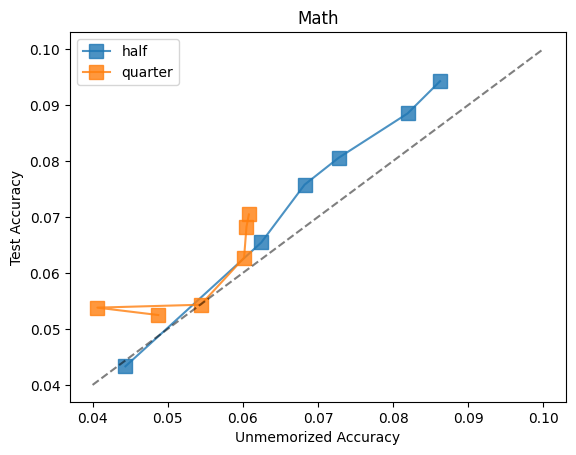

In [7]:
# plt.plot(ratios_dict5_3["unmemorized_acc_cummax"], ratios_dict5_3["avg_test_acc"], "s-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 3")
plt.plot(ratios_dict5_6_half["unmemorized_acc_cummax"], ratios_dict5_6_half["avg_test_acc"], "s-", markersize=10, c="C0", alpha=0.8, label="half")
plt.plot(ratios_dict5_12_quarter["unmemorized_acc_cummax"], ratios_dict5_12_quarter["avg_test_acc"], "s-", markersize=10, c="C1", alpha=0.8, label="quarter")
# plt.plot(ratios_dict5_24_eighth["unmemorized_acc_cummax"], ratios_dict5_24_eighth["avg_test_acc"], "s-", markersize=10, c="C2", alpha=0.8, label="eighth")

plt.plot([0.04, 0.1], [0.04, 0.1], "--", c="black", alpha=0.5)

plt.legend()

plt.title("Math")
plt.xlabel("Unmemorized Accuracy")
plt.ylabel("Test Accuracy")

plt.savefig("delete.png")

(array([5451., 1198.,  491.,  211.,   99.,   50.]),
 array([-0.1,  0.1,  0.3,  0.5,  0.7,  0.9,  1.1]),
 <BarContainer object of 6 artists>)

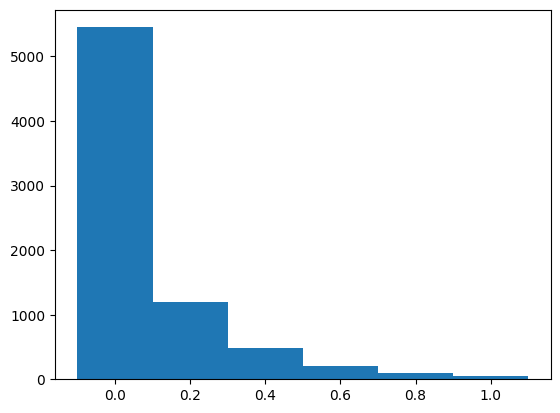

In [25]:
plt.hist(ratios_dict5_3["unmemorized_acc_cummax_full"].max(axis=0), bins = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1])

In [26]:
subsample_idxs = np.where(np.load("ckpts/math_orig_6epochs_full_lr5e-07_bs128/unmemorized_acc_cummax_full.npy").max(axis=0)> 0)[0]


In [27]:
unmemorized_acc_cummax_all = np.load("ckpts/math_orig_6epochs_full_lr5e-07_bs128/unmemorized_acc_cummax_full.npy").max(axis=0)
num_subsample_idxs = len(np.where(unmemorized_acc_cummax_all>0)[0])
sorted_idxs = np.argsort(unmemorized_acc_cummax_all) #lowest to highest
subsample_idxs2 = sorted_idxs[:num_subsample_idxs]

(array([3288.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         924.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 <BarContainer object of 10 artists>)

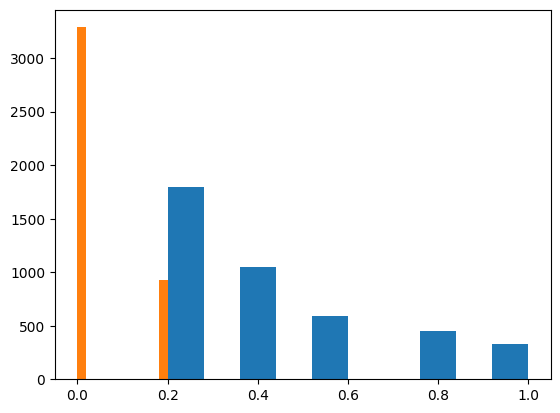

In [31]:
plt.hist(unmemorized_acc_cummax_all[subsample_idxs])

plt.hist(unmemorized_acc_cummax_all[subsample_idxs2])


In [28]:
subsample_idxs

array([   0,    1,    2, ..., 7484, 7493, 7498])

In [29]:
np.sort(subsample_idxs2)

array([   4,    6,    8, ..., 7496, 7497, 7499])

In [22]:
ratios_dict5_3["unmemorized_acc_cummax_full"][-1]

array([0. , 0.2, 0.8, ..., 0. , 0. , 0. ])

In [19]:
ratios_dict5_3["unmemorized_acc_cummax"]

array([0.06381333, 0.07237333, 0.08253333])

Text(0.5, 0, 'Ratio of correct and unmemorized train examples')

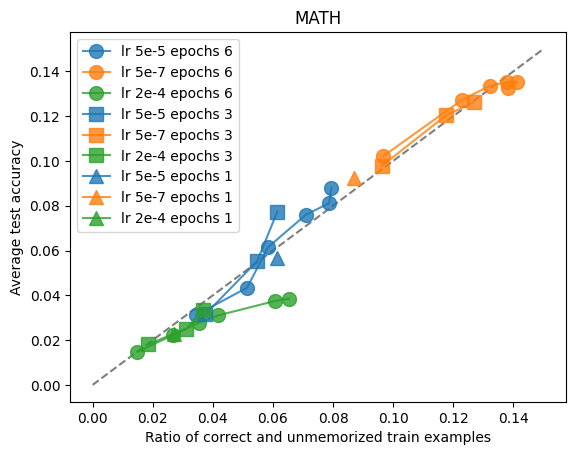

In [28]:
# plt.plot(ratios_dict5["unmemorized_acc_cummax"], ratios_dict5["avg_test_acc"], 'o-', 
# plt.plot(ratios_dict7["unmemorized_acc_cummax"], ratios_dict7["avg_test_acc"], 'o-')
# plt.plot(ratios_dict4["unmemorized_acc_cummax"], ratios_dict4["avg_test_acc"], 'o-')


# plt.plot(ratios_dict5_3["unmemorized_acc_cummax"], ratios_dict5_3["avg_test_acc"], 'o-')
# plt.plot(ratios_dict7_3["unmemorized_acc_cummax"], ratios_dict7_3["avg_test_acc"], 'o-')
# plt.plot(ratios_dict4_3["unmemorized_acc_cummax"], ratios_dict4_3["avg_test_acc"], 'o-')


# plt.plot(ratios_dict5_1["unmemorized_acc_cummax"], ratios_dict5_1["avg_test_acc"], 'o-')
# plt.plot(ratios_dict7_1["unmemorized_acc_cummax"], ratios_dict7_1["avg_test_acc"], 'o-')
# plt.plot(ratios_dict4_1["unmemorized_acc_cummax"], ratios_dict4_1["avg_test_acc"], 'o-')

# plt.plot([0, 0.15], [0, 0.15], 'k--')



plt.plot([0, 0.15], [0, 0.15], "--", color="black", alpha=0.5)


plt.plot(ratios_dict5["unmemorized_acc_cummax"], ratios_dict5["avg_test_acc"], "o-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 6")
plt.plot(ratios_dict7["unmemorized_acc_cummax"], ratios_dict7["avg_test_acc"], "o-", markersize=10, c="C1", alpha=0.8, label="lr 5e-7 epochs 6")
plt.plot(ratios_dict4["unmemorized_acc_cummax"], ratios_dict4["avg_test_acc"], "o-", markersize=10, c="C2", alpha=0.8, label="lr 2e-4 epochs 6")
# plt.plot(ratios_dict7_2["ratio_memorized1"]+ratios_dict7_2["ratio_unmemorized"], ratios_dict7_2["avg_test_acc"], "o-")


plt.plot(ratios_dict5_3["unmemorized_acc_cummax"], ratios_dict5_3["avg_test_acc"], "s-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 3")
plt.plot(ratios_dict7_3["unmemorized_acc_cummax"], ratios_dict7_3["avg_test_acc"], "s-", markersize=10, c="C1", alpha=0.8, label="lr 5e-7 epochs 3")
plt.plot(ratios_dict4_3["unmemorized_acc_cummax"], ratios_dict4_3["avg_test_acc"], "s-", markersize=10, c="C2", alpha=0.8, label="lr 2e-4 epochs 3")

# plt.plot(ratios_dict5_6_half["ratio_memorized1"]+ratios_dict5_6_half["ratio_unmemorized"], ratios_dict5_6_half["avg_test_acc"], "P-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 3")
# plt.plot(ratios_dict5_12_quarter["ratio_memorized1"]+ratios_dict5_12_quarter["ratio_unmemorized"], ratios_dict5_12_quarter["avg_test_acc"], "P-", markersize=10, c="C1", alpha=0.8, label="lr 5e-7 epochs 3")
# plt.plot(ratios_dict5_24_eighth["ratio_memorized1"]+ratios_dict5_24_eighth["ratio_unmemorized"], ratios_dict5_24_eighth["avg_test_acc"], "P-", markersize=10, c="C2", alpha=0.8, label="lr 2e-4 epochs 3")

plt.plot(ratios_dict5_1["unmemorized_acc_cummax"], ratios_dict5_1["avg_test_acc"], "^-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 1")
plt.plot(ratios_dict7_1["unmemorized_acc_cummax"], ratios_dict7_1["avg_test_acc"], "^-", markersize=10, c="C1", alpha=0.8, label="lr 5e-7 epochs 1")
plt.plot(ratios_dict4_1["unmemorized_acc_cummax"], ratios_dict4_1["avg_test_acc"], "^-", markersize=10, c="C2", alpha=0.8, label="lr 2e-4 epochs 1")


plt.legend()


plt.title("MATH")

plt.ylabel("Average test accuracy")

plt.xlabel("Ratio of correct and unmemorized train examples")

In [24]:
ratios_dict5_1 = get_ratios2(stats_dict5_1, acc_threhshold, perp_threshold)
ratios_dict7_1 = get_ratios2(stats_dict7_1, acc_threhshold, perp_threshold)
ratios_dict4_1 = get_ratios2(stats_dict4_1, acc_threhshold, perp_threshold)

(1, 7500)
(1, 7500)
(1, 7500)
(1, 7500)
(1, 7500)
(1, 7500)


In [25]:
ratios_dict5_3 = get_ratios2(stats_dict5_3, acc_threhshold, perp_threshold)
ratios_dict7_3 = get_ratios2(stats_dict7_3, acc_threhshold, perp_threshold)
ratios_dict4_3 = get_ratios2(stats_dict4_3, acc_threhshold, perp_threshold)

(3, 7500)
(3, 7500)
(3, 7500)
(3, 7500)
(3, 7500)
(3, 7500)


In [122]:
ratios_dict5["ratio_memorized1"]+ratios_dict5["ratio_unmemorized"]

array([0.01133333, 0.02626667, 0.03893333, 0.0464    , 0.05306667,
       0.05346667])

In [18]:
ratios_dict5["unmemorized_acc_cummax"]

array([0.036     , 0.06125333, 0.07605333, 0.09138667, 0.10112   ,
       0.10226667])

In [19]:
ratios_dict5["avg_test_acc"]

array([0.03124, 0.0434 , 0.0614 , 0.07604, 0.08112, 0.088  ])

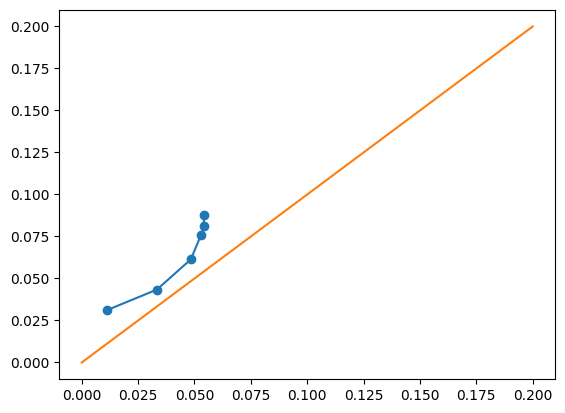

In [116]:
plt.plot(ratios_dict5["unmemorized_acc_cummax"], ratios_dict5["avg_test_acc"], "o-")
plt.plot([0, 0.2], [0, 0.2])

In [ ]:
ratios_dict5["test_mag"]

Text(0.5, 0, 'Ratio of correct and unmemorized train examples')

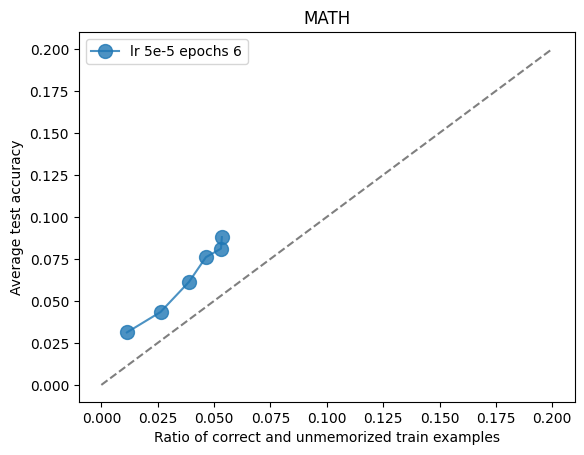

In [121]:


plt.plot([0, 0.2], [0, 0.2], "--", color="black", alpha=0.5)


plt.plot(ratios_dict5["ratio_memorized1"]+ratios_dict5["ratio_unmemorized"], ratios_dict5["avg_test_acc"], "o-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 6")
# plt.plot(ratios_dict7["ratio_memorized1"]+ratios_dict7["ratio_unmemorized"], ratios_dict7["avg_test_acc"], "o-", markersize=10, c="C1", alpha=0.8, label="lr 5e-7 epochs 6")
# plt.plot(ratios_dict4["ratio_memorized1"]+ratios_dict4["ratio_unmemorized"], ratios_dict4["avg_test_acc"], "o-", markersize=10, c="C2", alpha=0.8, label="lr 2e-4 epochs 6")


# plt.plot(ratios_dict5_3["ratio_memorized1"]+ratios_dict5_3["ratio_unmemorized"], ratios_dict5_3["avg_test_acc"], "s-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 3")
# plt.plot(ratios_dict7_3["ratio_memorized1"]+ratios_dict7_3["ratio_unmemorized"], ratios_dict7_3["avg_test_acc"], "s-", markersize=10, c="C1", alpha=0.8, label="lr 5e-7 epochs 3")
# plt.plot(ratios_dict4_3["ratio_memorized1"]+ratios_dict4_3["ratio_unmemorized"], ratios_dict4_3["avg_test_acc"], "s-", markersize=10, c="C2", alpha=0.8, label="lr 2e-4 epochs 3")


# plt.plot(ratios_dict5_1["ratio_memorized1"]+ratios_dict5_1["ratio_unmemorized"], ratios_dict5_1["avg_test_acc"], "^-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 1")
# plt.plot(ratios_dict7_1["ratio_memorized1"]+ratios_dict7_1["ratio_unmemorized"], ratios_dict7_1["avg_test_acc"], "^-", markersize=10, c="C1", alpha=0.8, label="lr 5e-7 epochs 1")
# plt.plot(ratios_dict4_1["ratio_memorized1"]+ratios_dict4_1["ratio_unmemorized"], ratios_dict4_1["avg_test_acc"], "^-", markersize=10, c="C2", alpha=0.8, label="lr 2e-4 epochs 1")


plt.legend()


plt.title("MATH")

plt.ylabel("Average test accuracy")

plt.xlabel("Ratio of correct and unmemorized train examples")